In [1]:
# text 
import re
import string

# data manipulation
import pandas as pd 
import numpy as np

# sqlite
import sqlite3
from sqlite3 import Error
import sqlalchemy
import blaze

# operating system
import os

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# modeling 
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import chi2





f:\Users\Tahar\Anacondanew\envs\ztdl\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
f:\Users\Tahar\Anacondanew\envs\ztdl\lib\site-packages\odo\backends\pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))
f:\Users\Tahar\Anacondanew\envs\ztdl\lib\site-packages\blaze\server\server.py:17: ExtDeprecationWarning: Importing flask.ext.cors is deprecated, use flask_cors instead.
  from flask.ext.cors import cross_origin


In [2]:
# Load data as a database
csv_path = 'assignment_data.csv'
db_path = 'data_assignment.db'

try:
    os.remove(db_path)
    blaze.odo(csv_path, 'sqlite:///data_assignment.db::data')
except:
    blaze.odo(csv_path, 'sqlite:///data_assignment.db::data')

sqlite3.enable_callback_tracebacks(True) # debug user defined functions

In [3]:
# connect to databse
con = sqlite3.connect(db_path)
cursor = con.cursor()

# inspect the header of the table
cursor.execute("PRAGMA table_info(data)")
print(cursor.fetchall())

[(0, 'id', 'BIGINT', 1, None, 0), (1, 'title', 'TEXT', 0, None, 0), (2, 'features', 'TEXT', 0, None, 0), (3, 'living_area', 'FLOAT', 0, None, 0), (4, 'total_area', 'FLOAT', 0, None, 0), (5, 'plot_area', 'FLOAT', 0, None, 0), (6, 'price', 'BIGINT', 1, None, 0)]


In [4]:
# check the 10 first rows
q_data_head  = "SELECT * FROM data LIMIT 10;"
print(cursor.execute(q_data_head).fetchall())

[(44525, 'Stunning 6 bedroom villa in the heart of the Golden Mile, Marbella', '', '', 918.0, '', 4400000), (44859, 'Villa for sale in Rocio de Nagüeles, Marbella Golden Mile', '', '', '', '', 2400000), (45465, 'One level 5 bedroom villa for sale in Nagüeles', '', '', 393.0, '', 1900000), (50685, 'Large estate for sale in Rocio de Nagueles', '', 0.0, 640.0, 0.0, 4250000), (130728, 'Palatial Villa on Marbella\x92s Golden Mile with Panoramic Sea Views', 'Fireplace, Elevator, Terrace, Mountain view, Freight Elevator, Air conditioning, Patio, Guest toilet, Garden, Balcony, Sea/lake view, Built-in kitchen', 0.0, 4903.0, 11000.0, 32000000), (130856, 'Large plot with fantastic views in Nagüeles', 'Mountain view', 0.0, 0.0, 5528.0, 2900000), (130857, 'Modern Design Penthouse on second line beach Golden Mile', 'Elevator, Terrace, Alarm system, Mountain view, Swimming pool, Air conditioning, Basement, Sea/lake view', 220.0, 530.0, 0.0, 3900000), (130897, 'Spacious Beachside Villa Casablanca Marb

In [5]:
# there is living area and total area, and it was suggested to choose the highest value between the two
# this is done with this function
def fill_total_area(living_area,total_area):
        if living_area>0 and total_area ==0:
            return living_area
        elif living_area>0 and total_area>0:
            return total_area
        elif living_area==0 and total_area>0:
            return total_area
        else:
            return 0

In [6]:
# the location is indicated within the title of every listing, this function uses regex to extract the location
def find_location(x):
    x = x.lower()
    x = ''.join([i for i in x if i not in string.punctuation ])
    x = re.sub('ü','u',x)
    try:
        return re.findall('quinta da marinha|golden mile|nagueles|alenquer',x)[0]
    except:
        return 'other'

In [7]:
# according to the assignment document, there are three main types: house, plots, appartments. I added other, to check
# those listing that could have been missed by the regex expressions within the following function
def find_type(title,plot_area,total_area):
    x = title.lower()
    x = ''.join([i for i in x if i not in string.punctuation ])
    if len(re.findall('\s?houses?\s|townhouses?|villa?|country|estate|moradia|quinta|residences?',x)) >=1:
        if total_area == 0 and plot_area >0:
            return 'plots'
        else:
            return 'house'
    elif len(re.findall('apartments?|penthouses?|duplex[es]?',x)) >=1:
        if total_area == 0 and plot_area >0:
            return 'plots'
        else:
            return 'apartments'
    elif len(re.findall('plots?|lands?',x)) >=1:
        return 'plots'
    else:
        return 'other'

In [8]:
# this function is to helps to help distinguish between plots area and the rest
def find_area(typ, plot_area, total_area):
    if typ == 'plots':
        return plot_area
    else:
        return total_area

In [9]:
q_add_column_location = "ALTER TABLE data ADD location CHAR;" # location col
q_add_column_type = "ALTER TABLE data ADD type CHAR;" # type col
q_add_column_total_area_new = "ALTER TABLE data ADD total_area_new FLOAT" # total_area_new
q_add_column_final_area = "ALTER TABLE data ADD final_area FLOAT" # final_area

cursor.execute(q_add_column_location)
cursor.execute(q_add_column_type)
cursor.execute(q_add_column_total_area_new)
cursor.execute(q_add_column_final_area)

con.commit()

In [10]:
# check that the new cols have been added successfuly 
cursor.execute("PRAGMA table_info(data);")
print(cursor.fetchall())

[(0, 'id', 'BIGINT', 1, None, 0), (1, 'title', 'TEXT', 0, None, 0), (2, 'features', 'TEXT', 0, None, 0), (3, 'living_area', 'FLOAT', 0, None, 0), (4, 'total_area', 'FLOAT', 0, None, 0), (5, 'plot_area', 'FLOAT', 0, None, 0), (6, 'price', 'BIGINT', 1, None, 0), (7, 'location', 'CHAR', 0, None, 0), (8, 'type', 'CHAR', 0, None, 0), (9, 'total_area_new', 'FLOAT', 0, None, 0), (10, 'final_area', 'FLOAT', 0, None, 0)]


In [11]:
# connect the functions
con.create_function('fill_total_area', 2, fill_total_area)
con.create_function('find_location',1, find_location)
con.create_function('find_type', 3, find_type)
con.create_function('find_area', 3, find_area)

In [12]:
# make sure that NULL and '' values are replaced with zero to avoid errors
cursor.execute('UPDATE data set total_area = 0 where total_area IS NULL or total_area==""') 
cursor.execute('UPDATE data set living_area = 0 where living_area IS NULL or living_area==""')
cursor.execute('UPDATE data set plot_area = 0 where plot_area IS NULL or plot_area==""')

In [13]:
cursor.execute('UPDATE data SET total_area_new = fill_total_area(living_area,total_area)')

In [14]:
cursor.execute('UPDATE data SET location = find_location(title)')

In [15]:
cursor.execute('UPDATE data SET type = find_type(title,plot_area,total_area_new)')

In [16]:
cursor.execute('UPDATE data SET final_area = plot_area+total_area_new')


In [17]:
# check the 10 first rows with new cols
print(cursor.execute(q_data_head).fetchall())

[(44525, 'Stunning 6 bedroom villa in the heart of the Golden Mile, Marbella', '', 0.0, 918.0, 0.0, 4400000, 'golden mile', 'house', 918.0, 918.0), (44859, 'Villa for sale in Rocio de Nagüeles, Marbella Golden Mile', '', 0.0, 0.0, 0.0, 2400000, 'nagueles', 'house', 0.0, 0.0), (45465, 'One level 5 bedroom villa for sale in Nagüeles', '', 0.0, 393.0, 0.0, 1900000, 'nagueles', 'house', 393.0, 393.0), (50685, 'Large estate for sale in Rocio de Nagueles', '', 0.0, 640.0, 0.0, 4250000, 'nagueles', 'house', 640.0, 640.0), (130728, 'Palatial Villa on Marbella\x92s Golden Mile with Panoramic Sea Views', 'Fireplace, Elevator, Terrace, Mountain view, Freight Elevator, Air conditioning, Patio, Guest toilet, Garden, Balcony, Sea/lake view, Built-in kitchen', 0.0, 4903.0, 11000.0, 32000000, 'golden mile', 'house', 4903.0, 15903.0), (130856, 'Large plot with fantastic views in Nagüeles', 'Mountain view', 0.0, 0.0, 5528.0, 2900000, 'nagueles', 'plots', 0.0, 5528.0), (130857, 'Modern Design Penthouse o

In [18]:
# create a new table with only variables that we need, and drop the rest
cursor.execute('CREATE TABLE data_backup AS SELECT id,title,features,type,location,total_area_new,plot_area, final_area,price FROM data')
cursor.execute('DROP TABLE data')
cursor.execute('ALTER TABLE data_backup RENAME TO data;')

In [19]:
# inspect the header of the new table
cursor.execute("PRAGMA table_info(data);")
print(cursor.fetchall())

[(0, 'id', 'INT', 0, None, 0), (1, 'title', 'TEXT', 0, None, 0), (2, 'features', 'TEXT', 0, None, 0), (3, 'type', 'TEXT', 0, None, 0), (4, 'location', 'TEXT', 0, None, 0), (5, 'total_area_new', 'REAL', 0, None, 0), (6, 'plot_area', 'REAL', 0, None, 0), (7, 'final_area', 'REAL', 0, None, 0), (8, 'price', 'INT', 0, None, 0)]


In [20]:
# query to extract only listings with a property type “quinta” or “house”;
cursor.execute('SELECT * FROM data WHERE type = "quinta" or type = "house"').fetchall()

[(44525,
  'Stunning 6 bedroom villa in the heart of the Golden Mile, Marbella',
  '',
  'house',
  'golden mile',
  918.0,
  0.0,
  918.0,
  4400000),
 (44859,
  'Villa for sale in Rocio de Nagüeles, Marbella Golden Mile',
  '',
  'house',
  'nagueles',
  0.0,
  0.0,
  0.0,
  2400000),
 (45465,
  'One level 5 bedroom villa for sale in Nagüeles',
  '',
  'house',
  'nagueles',
  393.0,
  0.0,
  393.0,
  1900000),
 (50685,
  'Large estate for sale in Rocio de Nagueles',
  '',
  'house',
  'nagueles',
  640.0,
  0.0,
  640.0,
  4250000),
 (130728,
  'Palatial Villa on Marbella\x92s Golden Mile with Panoramic Sea Views',
  'Fireplace, Elevator, Terrace, Mountain view, Freight Elevator, Air conditioning, Patio, Guest toilet, Garden, Balcony, Sea/lake view, Built-in kitchen',
  'house',
  'golden mile',
  4903.0,
  11000.0,
  15903.0,
  32000000),
 (130857,
  'Modern Design Penthouse on second line beach Golden Mile',
  'Elevator, Terrace, Alarm system, Mountain view, Swimming pool, Air con

In [21]:
def check_for_pool(features):
    features = features.lower()
    if len(re.findall('pool', features)) >= 1:
        return 'pool'

In [22]:
con.create_function('check_for_pool',1,check_for_pool)

In [23]:
# query to extract only listings of properties with a pool
cursor.execute('SELECT * FROM data WHERE check_for_pool(features)="pool"').fetchall()

[(130857,
  'Modern Design Penthouse on second line beach Golden Mile',
  'Elevator, Terrace, Alarm system, Mountain view, Swimming pool, Air conditioning, Basement, Sea/lake view',
  'house',
  'golden mile',
  530.0,
  0.0,
  530.0,
  3900000),
 (130897,
  'Spacious Beachside Villa Casablanca Marbella Golden Mile',
  'Fireplace, Elevator, Terrace, Alarm system, Swimming pool, Basement, Guest toilet, Built-in kitchen',
  'house',
  'golden mile',
  450.0,
  600.0,
  1050.0,
  3148000),
 (130917,
  'Modern Designer Villa with Stunning Views Golden Mile',
  'Fireplace, Terrace, Alarm system, Mountain view, Swimming pool, Air conditioning, Basement, Patio, Guest toilet, Garden, Sea/lake view, Built-in kitchen',
  'house',
  'golden mile',
  845.0,
  1000.0,
  1845.0,
  2950000),
 (130978,
  'Beautiful Villa at the top of Nagüeles with panoramic views',
  'Security system, Fireplace, Terrace, Jacuzzi, Air conditioning, Swimming pool, Basement, Sauna, Gym, Guest toilet, Sea/lake view, Buil

In [24]:
# query to extract listings where a property type is not “plot”
cursor.execute('SELECT * FROM data WHERE type != "plots"').fetchall()

[(44525,
  'Stunning 6 bedroom villa in the heart of the Golden Mile, Marbella',
  '',
  'house',
  'golden mile',
  918.0,
  0.0,
  918.0,
  4400000),
 (44859,
  'Villa for sale in Rocio de Nagüeles, Marbella Golden Mile',
  '',
  'house',
  'nagueles',
  0.0,
  0.0,
  0.0,
  2400000),
 (45465,
  'One level 5 bedroom villa for sale in Nagüeles',
  '',
  'house',
  'nagueles',
  393.0,
  0.0,
  393.0,
  1900000),
 (50685,
  'Large estate for sale in Rocio de Nagueles',
  '',
  'house',
  'nagueles',
  640.0,
  0.0,
  640.0,
  4250000),
 (130728,
  'Palatial Villa on Marbella\x92s Golden Mile with Panoramic Sea Views',
  'Fireplace, Elevator, Terrace, Mountain view, Freight Elevator, Air conditioning, Patio, Guest toilet, Garden, Balcony, Sea/lake view, Built-in kitchen',
  'house',
  'golden mile',
  4903.0,
  11000.0,
  15903.0,
  32000000),
 (130857,
  'Modern Design Penthouse on second line beach Golden Mile',
  'Elevator, Terrace, Alarm system, Mountain view, Swimming pool, Air con

In [25]:
# query calculating the average price per square meter of all apartments in Nagüeles
cursor.execute('SELECT AVG(price) as data FROM data WHERE location="nagueles"').fetchone()

(1009397.6588191331,)

## Python Part 1

In [26]:
db_name = db_path
table_name = 'data'

engine = sqlalchemy.create_engine("sqlite:///%s" % db_name, execution_options={"sqlite_raw_colnames": True})
df = pd.read_sql_table(table_name, engine)

In [27]:
df.head()

,id,title,features,type,location,total_area_new,plot_area,final_area,price
0,44525,Stunning 6 bedroom villa in the heart of the G...,,house,golden mile,918.0,0.0,918.0,4400000
1,44859,"Villa for sale in Rocio de Nagüeles, Marbella ...",,house,nagueles,0.0,0.0,0.0,2400000
2,45465,One level 5 bedroom villa for sale in Nagüeles,,house,nagueles,393.0,0.0,393.0,1900000
3,50685,Large estate for sale in Rocio de Nagueles,,house,nagueles,640.0,0.0,640.0,4250000
4,130728,Palatial Villa on Marbellas Golden Mile with ...,"Fireplace, Elevator, Terrace, Mountain view, F...",house,golden mile,4903.0,11000.0,15903.0,32000000


In [28]:
df.shape

(4910, 9)

In [29]:
df['type'].value_counts()

house         3534
apartments    1113
plots          263
Name: type, dtype: int64

In [30]:
df['location'].value_counts()

nagueles             2676
quinta da marinha    1170
alenquer              755
golden mile           309
Name: location, dtype: int64

### Task 1&2: Classify the type, then the location

For this classification task i will use TFIDF vectorization on title to classify both type and location. However, there will be two main actions before moving to modeling: 
- impute missing data for both area and price
- clean text from any words used before to label type and location

In [31]:
# check if there is any anomalies for price and area

print('number of listings with zero values area is: {}'.format(df[df['final_area'] ==0].shape[0]))
print('number of listings with zero values price is: {}'.format(df[df['price'] ==0].shape[0]))
print('number of listings with zero values area and price is: {}'.format(df[(df['price'] ==0)&(df['final_area'] ==0)].shape[0]))
      

number of listings with zero values area is: 324
number of listings with zero values price is: 233
number of listings with zero values area and price is: 39


In [32]:
# the listings that have zero values for either area or price would be assumed as error entry, however,
# there is a need to investigate those listings that have zero values for are and price
df[(df['price'] ==0)&(df['final_area'] ==0)]

,id,title,features,type,location,total_area_new,plot_area,final_area,price
135,146660,"Duplex Penthouse for Rent in Las Cañas Beach, ...","Marble floors, Dining room, Air conditioning, ...",house,golden mile,0.0,0.0,0.0,0
137,146679,"Apartment for Rent in Oasis de Marbella, Marb...",.,apartments,golden mile,0.0,0.0,0.0,0
386,245869,"Apartment for Rent in Hacienda Nagüeles II, M...","Transport near, Security service 24h, Mountain...",apartments,nagueles,0.0,0.0,0.0,0
391,245875,"Villa for Rent in Rocio de Nagüeles, Marbella...",.,house,nagueles,0.0,0.0,0.0,0
393,245877,"Villa for Rent in Rocio de Nagüeles, Marbella...",.,house,nagueles,0.0,0.0,0.0,0
460,262880,"Apartment for rent in Los Pinos de Nagüeles, M...",,apartments,nagueles,0.0,0.0,0.0,0
681,363086,"Duplex for rent in Costa Nagüeles I, Marbella ...",,apartments,nagueles,0.0,0.0,0.0,0
719,447533,"Penthouse For Rent in Nagüeles, Marbella",Situation \n \n...,house,nagueles,0.0,0.0,0.0,0
882,500557,Fabulous and unique Villa in Quinta da Marinha...,RoomsBathroom (s) 7 \nTotal bedroom(s) 5 \nSur...,house,quinta da marinha,0.0,0.0,0.0,0
1331,648121,"Penthouse for Rent in Oasis de Marbella, Marb...","Air conditioning, Central heating, Fully fitte...",house,golden mile,0.0,0.0,0.0,0


**observation:** The 39 listings that are missing area and price are going to be discarded from the dataset since it represents only 0.79% of total number of listings and it is to save time. Another way to handle this data is by imputing by average/median or using a regression

In [33]:
# for the listings where they have either area missing or price missing we impute the missing data using average or median
# to do so, we first inspect the distribution of both area and price

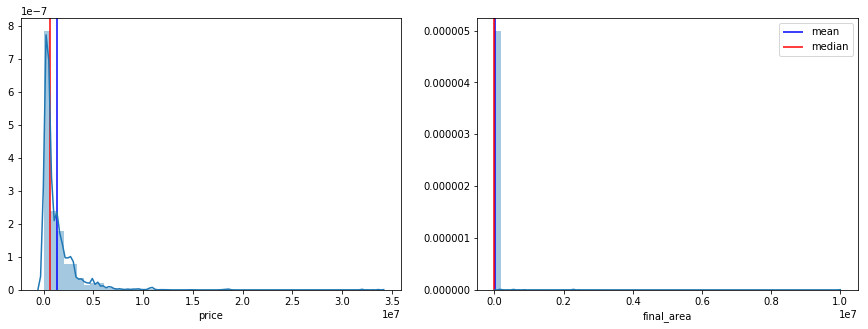

In [34]:
# check the distributions of the listings that have zero values for area or price
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.distplot(df['price'][df['price']>0], ax= ax[0])
ax[0].vlines(df['price'][df['price']>0].mean(),0,df['price'].max(),color='blue',label='mean')
ax[0].vlines(df['price'][df['price']>0].median(),0,df['price'].max(),color='red',label='median')

sns.distplot(df['final_area'][df['final_area']>0], ax= ax[1])
ax[1].vlines(df['final_area'][df['final_area']>0].mean(),0,df['final_area'].max(),color='blue',label='mean')
ax[1].vlines(df['final_area'][df['final_area']>0].median(),0,df['final_area'].max(),color='red',label='median')
plt.legend()

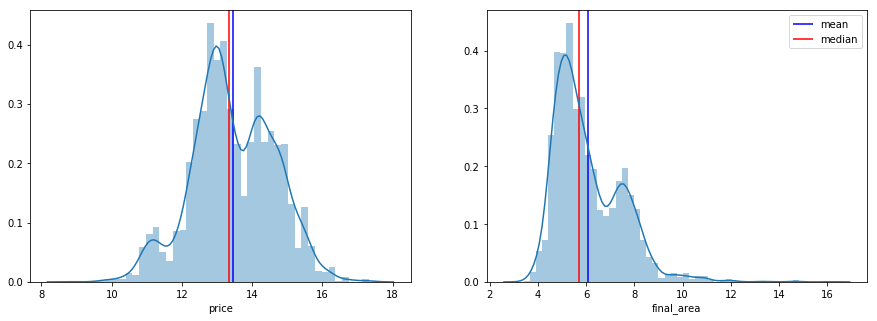

In [35]:
# log transformation
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.distplot(df['price'][df['price']>0].apply(np.log), ax= ax[0])
ax[0].vlines(df['price'][df['price']>0].apply(np.log).mean(),0,df['price'].max(),color='blue',label='mean')
ax[0].vlines(df['price'][df['price']>0].apply(np.log).median(),0,df['price'].max(),color='red',label='median')

sns.distplot(df['final_area'][df['final_area']>0].apply(np.log), ax= ax[1])
ax[1].vlines(df['final_area'][df['final_area']>0].apply(np.log).mean(),0,df['final_area'].max(),color='blue',label='mean')
ax[1].vlines(df['final_area'][df['final_area']>0].apply(np.log).median(),0,df['final_area'].max(),color='red',label='median')
plt.legend()

In [36]:
print('Final area: the mean is [{:.2f}], the median is [{:.2f}], and the std is [{:.2f}]'.format(df['final_area'][(df['price'] !=0)&(df['final_area'] !=0)].mean(),df['final_area'][(df['price'] !=0)&(df['final_area'] !=0)].median(),df['final_area'][(df['price'] !=0)&(df['final_area'] !=0)].std()))
print('Price: the mean is [{:.2f}], the median is [{:.2f}], and the std is [{:.2f}]'.format(df['price'][(df['price'] !=0)&(df['final_area'] !=0)].mean(),df['price'][(df['price'] !=0)&(df['final_area'] !=0)].median(),df['price'][(df['price'] !=0)&(df['final_area'] !=0)].std()))


Final area: the mean is [5860.50], the median is [300.00], and the std is [162946.96]
Price: the mean is [1284792.54], the median is [595000.00], and the std is [1963099.44]


In [37]:
print('Final area (Houses): the mean is [{:.2f}], the median is [{:.2f}], and the std is [{:.2f}]'.format(df['final_area'][df['type']=='house'][(df['price'] !=0)&(df['final_area'] !=0)].mean(),df['final_area'][df['type']=='house'][(df['price'] !=0)&(df['final_area'] !=0)].median(),df['final_area'][df['type']=='house'][(df['price'] !=0)&(df['final_area'] !=0)].std()))
print('Price (Houses): the mean is [{:.2f}], the median is [{:.2f}], and the std is [{:.2f}]'.format(df['price'][df['type']=='house'][(df['price'] !=0)&(df['final_area'] !=0)].mean(),df['price'][df['type']=='house'][(df['price'] !=0)&(df['final_area'] !=0)].median(),df['price'][df['type']=='house'][(df['price'] !=0)&(df['final_area'] !=0)].std()))


Final area (Houses): the mean is [7549.12], the median is [425.50], and the std is [193605.33]
Price (Houses): the mean is [1536485.40], the median is [892500.00], and the std is [2116805.24]


In [38]:
print('Final area (plots): the mean is [{:.2f}], the median is [{:.2f}], and the std is [{:.2f}]'.format(df['final_area'][df['type']=='plots'][(df['price'] !=0)&(df['final_area'] !=0)].mean(),df['final_area'][df['type']=='plots'][(df['price'] !=0)&(df['final_area'] !=0)].median(),df['final_area'][df['type']=='plots'][(df['price'] !=0)&(df['final_area'] !=0)].std()))
print('Price (plots): the mean is [{:.2f}], the median is [{:.2f}], and the std is [{:.2f}]'.format(df['price'][df['type']=='plots'][(df['price'] !=0)&(df['final_area'] !=0)].mean(),df['price'][df['type']=='plots'][(df['price'] !=0)&(df['final_area'] !=0)].median(),df['price'][df['type']=='plots'][(df['price'] !=0)&(df['final_area'] !=0)].std()))


Final area (plots): the mean is [8827.38], the median is [1811.50], and the std is [18720.81]
Price (plots): the mean is [1722115.07], the median is [624000.00], and the std is [2781312.64]


In [39]:
print('Final area (apartments): the mean is [{:.2f}], the median is [{:.2f}], and the std is [{:.2f}]'.format(df['final_area'][df['type']=='apartments'][(df['price'] !=0)&(df['final_area'] !=0)].mean(),df['final_area'][df['type']=='apartments'][(df['price'] !=0)&(df['final_area'] !=0)].median(),df['final_area'][df['type']=='apartments'][(df['price'] !=0)&(df['final_area'] !=0)].std()))
print('Price (apartments): the mean is [{:.2f}], the median is [{:.2f}], and the std is [{:.2f}]'.format(df['price'][df['type']=='apartments'][(df['price'] !=0)&(df['final_area'] !=0)].mean(),df['price'][df['type']=='apartments'][(df['price'] !=0)&(df['final_area'] !=0)].median(),df['price'][df['type']=='apartments'][(df['price'] !=0)&(df['final_area'] !=0)].std()))


Final area (apartments): the mean is [151.43], the median is [122.50], and the std is [212.53]
Price (apartments): the mean is [434966.11], the median is [320000.00], and the std is [384512.81]


**Observations:** We can observe that the distributions are skewed in general and when we have a look at Houses and Apartments we see that the skew could be caused by Houses and plots mainly. Houses or plots have high variations in both area and price, we could assume that there are Houses with small areas and that could be expensive due to several reasons (ie: location). On the other hand, apartments seem to be less skewed than Houses. 

**imputing data actions**
- For houses/plots we impute using the mean for Area, and median for price
- For apartments we impute using the median for both

*Note:* better imputting can be realized using regressiong as mentioned before

In [40]:
house_area_ix = df['final_area'][df['type']=='house'][df['final_area']==0].index
house_price_ix = df['price'][df['type']=='house'][df['price']==0].index

In [41]:
df.iloc[house_area_ix, 7 ] = df['final_area'][df['type']=='house'][df['final_area']>0].mean()
df.iloc[house_price_ix, 8 ] = df['price'][df['type']=='house'][df['price']>0].median()

In [42]:
plots_area_ix = df['final_area'][df['type']=='plots'][df['final_area']==0].index
plots_price_ix = df['price'][df['type']=='plots'][df['price']==0].index

In [43]:
df.iloc[plots_area_ix, 7 ] = df['final_area'][df['type']=='house'][df['final_area']>0].mean()
df.iloc[plots_price_ix, 8 ] = df['price'][df['type']=='house'][df['price']>0].median()

In [44]:
apt_area_ix = df['final_area'][df['type']=='apartments'][df['final_area']==0].index
apt_price_ix = df['price'][df['type']=='apartments'][df['price']==0].index

In [45]:
df.iloc[apt_area_ix, 7 ] = df['final_area'][df['type']=='apartments'][df['final_area']>0].median()
df.iloc[apt_price_ix, 8 ] = df['price'][df['type']=='apartments'][df['price']>0].median()

In [46]:
df.head()

,id,title,features,type,location,total_area_new,plot_area,final_area,price
0,44525,Stunning 6 bedroom villa in the heart of the G...,,house,golden mile,918.0,0.0,918.00000,4400000.0
1,44859,"Villa for sale in Rocio de Nagüeles, Marbella ...",,house,nagueles,0.0,0.0,7451.25294,2400000.0
2,45465,One level 5 bedroom villa for sale in Nagüeles,,house,nagueles,393.0,0.0,393.00000,1900000.0
3,50685,Large estate for sale in Rocio de Nagueles,,house,nagueles,640.0,0.0,640.00000,4250000.0
4,130728,Palatial Villa on Marbellas Golden Mile with ...,"Fireplace, Elevator, Terrace, Mountain view, F...",house,golden mile,4903.0,11000.0,15903.00000,32000000.0


In [47]:
#sum(df['final_area'] == 0), sum(df['price'] == 0) # to check if all imputation have been done correctly

In [48]:
# before proceeding with classification, wee need to clean the titles from type and location, we use the similar function
# as the one used for extraction, but this time we replace type or location whenever we find them
def subtitute_type(title):
    x = title.lower()
    x = ''.join([i for i in x if i not in string.punctuation ])
    p = '\s?houses?\s|townhouses?|villa?|country|estate|moradia|quinta|residences?|apartments?|penthouses?|duplex[es]?|plots?|lands?'
    f = re.findall(p,x)
    for i in f:
        x = x.replace(i,'')
    return x

In [49]:
df['new_title'] = df['title'].apply(subtitute_type) # clean title from type and location

In [50]:
# Next we need to transform type and location to ordinal data
def create_class(df,cls):
    df[cls+'_id']  = df[cls].factorize()[0]
    cls_id_df = df[[cls, cls+'_id']].drop_duplicates().sort_values(cls+'_id')
    cls_to_id = dict(cls_id_df.values)
    id_to_cls = dict(cls_id_df[[cls+'_id', cls]].values)
    return cls_id_df, cls_to_id, id_to_cls

In [51]:
type_id_df, type_to_id, id_to_type = create_class(df,'type')
location_id_df, location_to_id, id_to_location = create_class(df,'location')
df.head()

,id,title,features,type,location,total_area_new,plot_area,final_area,price,new_title,type_id,location_id
0,44525,Stunning 6 bedroom villa in the heart of the G...,,house,golden mile,918.0,0.0,918.00000,4400000.0,stunning 6 bedroom in the heart of the golden...,0,0
1,44859,"Villa for sale in Rocio de Nagüeles, Marbella ...",,house,nagueles,0.0,0.0,7451.25294,2400000.0,for sale in rocio de nagüeles marbella golden...,0,1
2,45465,One level 5 bedroom villa for sale in Nagüeles,,house,nagueles,393.0,0.0,393.00000,1900000.0,one level 5 bedroom for sale in nagüeles,0,1
3,50685,Large estate for sale in Rocio de Nagueles,,house,nagueles,640.0,0.0,640.00000,4250000.0,large for sale in rocio de nagueles,0,1
4,130728,Palatial Villa on Marbellas Golden Mile with ...,"Fireplace, Elevator, Terrace, Mountain view, F...",house,golden mile,4903.0,11000.0,15903.00000,32000000.0,palatial on marbellas golden mile with panor...,0,0


#### 1- Type

In [52]:
df_clone = df[['new_title','type','price','final_area','location','type_id','location_id']].copy() # make copy of orignal dataset

In [53]:
# fit Tfidfvectorizer on new_title
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
type_features = tfidf.fit_transform(df_clone['new_title']).toarray()
type_labels = df_clone.type_id
type_features.shape

(4910, 661)

In [54]:
# we can use chi-square test to find the terms that are the most correlated with each of the types:
N = 5
for typ, type_id in sorted(type_to_id.items()):
    features_chi2 = chi2(type_features, type_labels == type_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(typ))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


# 'apartments':
  . Most correlated unigrams:
. marinha
. da
. middle
. ground
. floor
  . Most correlated bigrams:
. da marinha
. middle floor
. sale nagüeles
. ground floor
. floor sale
# 'house':
  . Most correlated unigrams:
. middle
. marinha
. da
. ground
. floor
  . Most correlated bigrams:
. floor nagüeles
. middle floor
. da marinha
. floor sale
. ground floor
# 'plots':
  . Most correlated unigrams:
. detached
. 131500
. details
. alenquer
. residential
  . Most correlated bigrams:
. sale 131500
. property details
. residential sale
. detached nagüeles
. alenquer sale


*note:* another deep step would be to investigate more those terms and see if they are actually meaningful or could be treated as stop words (ie: "sale 131500")

In [55]:
# this function helps to concat "location","area", and "price" with text tokens 
def concat(cls, X, Xtfidf):
    cls_dummy = np.array(pd.get_dummies(X[cls]))
    area_price = np.array(X[['final_area','price']])
    features_rem = np.hstack((cls_dummy,area_price))
    return np.hstack((Xtfidf, features_rem))

In [56]:
type_features = concat('type', df_clone, type_features)

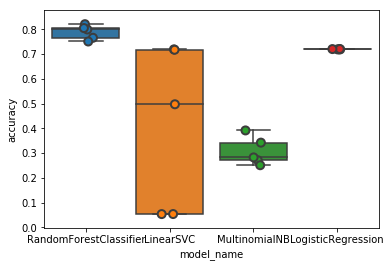

In [57]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, type_features, type_labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))


cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [58]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.408463
LogisticRegression        0.719756
MultinomialNB             0.308008
RandomForestClassifier    0.788579
Name: accuracy, dtype: float64

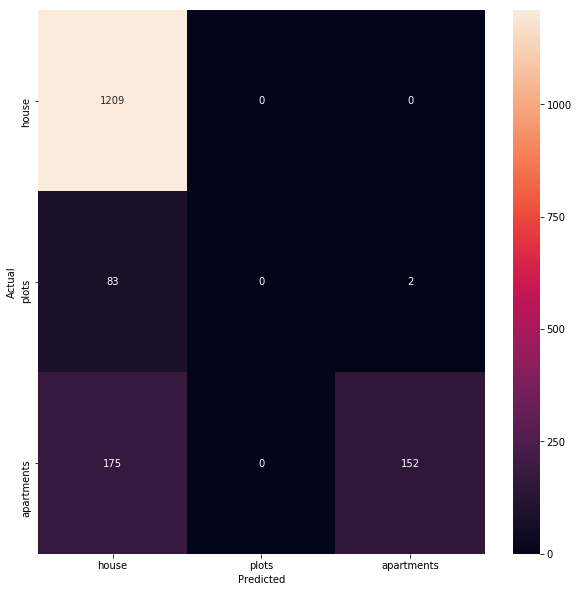

In [59]:
model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(type_features, type_labels, df_clone.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=type_id_df.type.values, yticklabels=type_id_df.type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### 2- Location

In [88]:
location_features = tfidf.fit_transform(df_clone['new_title']).toarray()
location_labels = df_clone.location_id
location_features.shape

(4910, 661)

In [89]:
N = 5
for location, location_id in sorted(location_to_id.items()):
    features_chi2 = chi2(location_features, location_labels == type_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(location))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


# 'alenquer':
  . Most correlated unigrams:
. cascais
. marinha
. alenquer
. da
. nagüeles
  . Most correlated bigrams:
. bedroom sale
. marinha cascais
. alenquer sale
. da marinha
. sale nagüeles
# 'golden mile':
  . Most correlated unigrams:
. cascais
. marinha
. alenquer
. da
. nagüeles
  . Most correlated bigrams:
. bedroom sale
. marinha cascais
. alenquer sale
. da marinha
. sale nagüeles
# 'nagueles':
  . Most correlated unigrams:
. cascais
. marinha
. alenquer
. da
. nagüeles
  . Most correlated bigrams:
. bedroom sale
. marinha cascais
. alenquer sale
. da marinha
. sale nagüeles
# 'quinta da marinha':
  . Most correlated unigrams:
. cascais
. marinha
. alenquer
. da
. nagüeles
  . Most correlated bigrams:
. bedroom sale
. marinha cascais
. alenquer sale
. da marinha
. sale nagüeles


In [90]:
location_features = concat('location', df_clone, location_features)

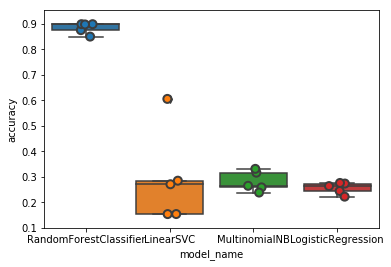

In [91]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, location_features, location_labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))


cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [93]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.293863
LogisticRegression        0.255998
MultinomialNB             0.281877
RandomForestClassifier    0.884531
Name: accuracy, dtype: float64

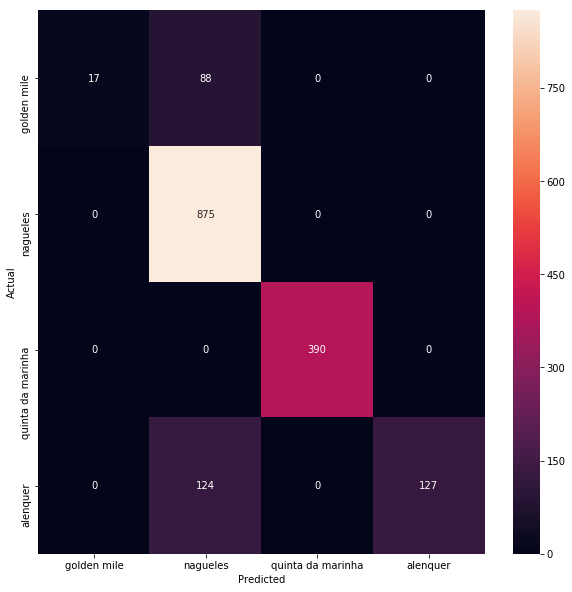

In [94]:
model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(location_features, location_labels, df_clone.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=location_id_df.location.values, yticklabels=location_id_df.location.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations**: We have done similar steps for both tasks and yet we see different results of the classification. I think there are two main reasons for this:
- 1- When doing labelling of types, i faced some challenges because there are listings that are for example house and they have plot. this compounding could cause the model to find difficulties to differentiate between different classes. one way to solve this would be to create a sub class of houses with plots. 
- 2- The second reason is class unbalance. the CU exists for both type and location, however, it is more present in type. A way to solve this would do being doing under sampling or over sampling combined with ensemble model

in addition there is more in deepth analysis to realize such as: do more feature engineering, feature selection, ensemble machine, better understanding of the text

***drop duplicates:*** for sake of investigation, we could start by dropping duplicates and see if there is any change. We stick with the basic pandas.drop_duplicates() methods (more advanced one should be considered)

In [66]:
df_dd = df.drop_duplicates(subset='new_title', keep=False)

In [67]:
# fit Tfidfvectorizer on new_title
type_features = tfidf.fit_transform(df_dd['new_title']).toarray()
type_labels = df_dd.type_id
type_features.shape, type_labels.shape

((1618, 361), (1618,))

In [68]:
# we can use chi-square test to find the terms that are the most correlated with each of the types:
N = 5
for typ, type_id in sorted(type_to_id.items()):
    features_chi2 = chi2(type_features, type_labels == type_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(typ))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


# 'apartments':
  . Most correlated unigrams:
. hacienda
. marinha
. da
. ground
. floor
  . Most correlated bigrams:
. hacienda nagüeles
. bedroom sale
. da marinha
. floor sale
. ground floor
# 'house':
  . Most correlated unigrams:
. cascais
. marinha
. da
. ground
. floor
  . Most correlated bigrams:
. hacienda nagüeles
. da marinha
. floor sale
. alenquer sale
. ground floor
# 'plots':
  . Most correlated unigrams:
. terreno
. 3000
. property
. alenquer
. details
  . Most correlated bigrams:
. lote terreno
. terreno com
. bedroom sale
. property details
. alenquer sale


In [69]:
type_features = concat('type', df_dd, type_features)

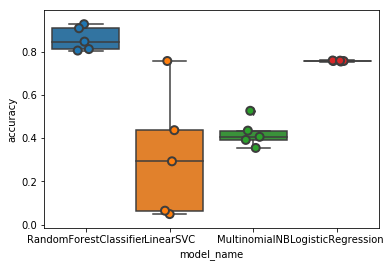

In [70]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, type_features, type_labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))


cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [71]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.320212
LogisticRegression        0.756494
MultinomialNB             0.422833
RandomForestClassifier    0.858947
Name: accuracy, dtype: float64

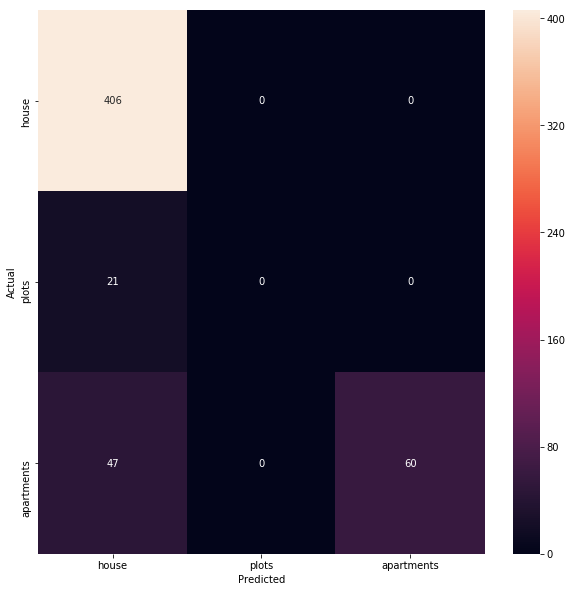

In [72]:
model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(type_features, type_labels, df_dd.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=type_id_df.type.values, yticklabels=type_id_df.type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

we see improvements for RandomForest, MultiNB, and logistic regression, but a decrease in performance for LinearSVC (more in depth analysis is needed)

### Task 3: identify pool, garage, and sea view

For this task i use features and title to extract pool, garage, and sea view. i create two columns and then use and OR where i only select 0 when the feature is absent both from title and features variables

In [73]:
def check_for_pool(features):
    features = features.lower()
    if len(re.findall('pools?', features)) >= 1:
        return 1
    else:
        return 0
    
def check_for_garage(features):
    features = features.lower()
    if len(re.findall('garages?', features)) >= 1:
        return 1
    else:
        return 0
    
def check_for_seaview(features):
    features = features.lower()
    if len(re.findall('sea\sview', features)) >= 1:
        return 1
    else:
        return 0

In [74]:
check_for_coolstuff = {'pool':check_for_pool,'garage':check_for_garage,'sea view':check_for_seaview}

In [75]:
def make_feature(df, feature):
    x = pd.DataFrame()
    x[feature] = df['features'].apply(check_for_coolstuff[feature])
    x[feature+'_bis'] = df['title'].apply(check_for_coolstuff[feature])
    x[feature+'_final'] = x.apply(np.max, axis=1)
    return x[feature+'_final']

In [76]:
df['pool'] = make_feature(df,'pool')

In [77]:
df['pool'].value_counts()

0    3350
1    1560
Name: pool, dtype: int64

In [78]:
df['garage'] = make_feature(df,'garage')

In [79]:
df['garage'].value_counts()

0    3732
1    1178
Name: garage, dtype: int64

In [80]:
df['sea view'] = make_feature(df,'sea view')

In [81]:
df['sea view'].value_counts()

0    4710
1     200
Name: sea view, dtype: int64

In [82]:
df.head()

,id,title,features,type,location,total_area_new,plot_area,final_area,price,new_title,type_id,location_id,pool,garage,sea view
0,44525,Stunning 6 bedroom villa in the heart of the G...,,house,golden mile,918.0,0.0,918.00000,4400000.0,stunning 6 bedroom in the heart of the golden...,0,0,0,0,0
1,44859,"Villa for sale in Rocio de Nagüeles, Marbella ...",,house,nagueles,0.0,0.0,7451.25294,2400000.0,for sale in rocio de nagüeles marbella golden...,0,1,0,0,0
2,45465,One level 5 bedroom villa for sale in Nagüeles,,house,nagueles,393.0,0.0,393.00000,1900000.0,one level 5 bedroom for sale in nagüeles,0,1,0,0,0
3,50685,Large estate for sale in Rocio de Nagueles,,house,nagueles,640.0,0.0,640.00000,4250000.0,large for sale in rocio de nagueles,0,1,0,0,0
4,130728,Palatial Villa on Marbellas Golden Mile with ...,"Fireplace, Elevator, Terrace, Mountain view, F...",house,golden mile,4903.0,11000.0,15903.00000,32000000.0,palatial on marbellas golden mile with panor...,0,0,0,0,1


In [83]:
df[['id','location','type','title','features','pool','sea view','garage']].to_csv('python_part_1.csv')

## Python Part 2

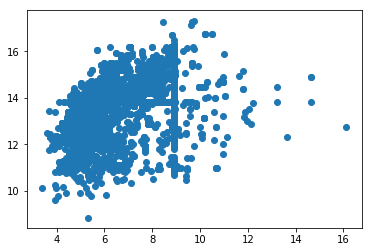

In [84]:
plt.scatter(df['final_area'].apply(np.log), df['price'].apply(np.log))

In [85]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
X = np.array(df_dd[['final_area','price']].apply(np.log))
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

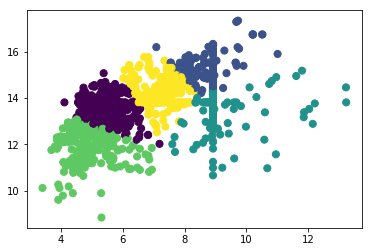

In [86]:
plt.scatter(x=X[:,0],y=X[:,1],c=y_kmeans, s=50, cmap='viridis')